# Week 8: Bisector Area of 2D Mesh
**Target**: 

In [1]:
# Packages
import numpy as np
import random
import matplotlib.pyplot as plt

# Self-defined functions
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from util import util

# Visualization
import pyvista as pv
from pyvista import examples

from scipy.spatial import Delaunay

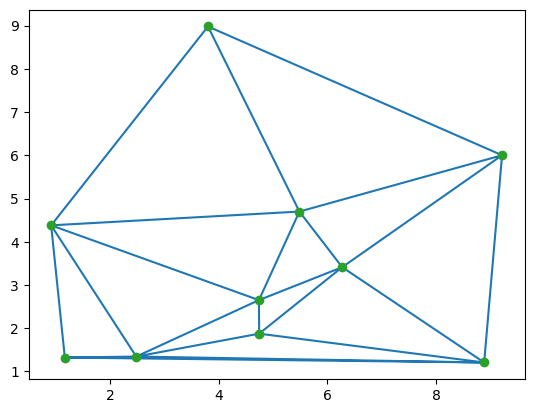

In [108]:
# 100 random points
points = np.random.rand(10, 2)*10

# Delaunay algorithm to triangulate the mesh
tri = Delaunay(points)

plt.triplot(points[:,0], points[:,1], tri.simplices)
plt.plot(points[:,0], points[:,1], 'o')
plt.show()

In [255]:
# test = problem_mesh_2D(points, tri.simplices)
test = problem_mesh_2D(points, faces)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


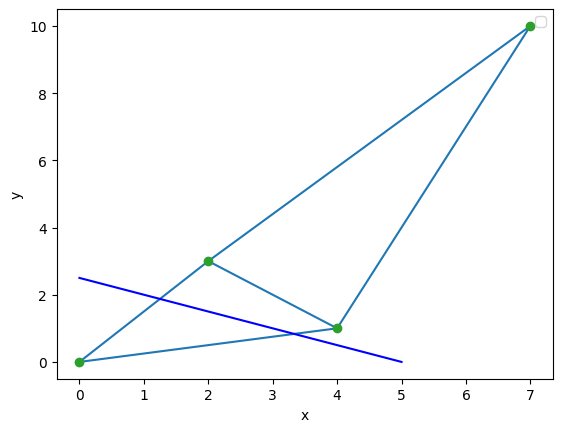

In [256]:
test.visualize()

In [253]:
A = np.array([2,3])
B = np.array([4,1])
C = np.array([0,0])
D = np.array([7,10])
points = np.array([A,B,C,D])
faces = [[0,1,2],[0,3,1]]

In [159]:
for face in tri.simplices:
    index_A, index_B, index_C = face
    A = points[index_A]
    B = points[index_B]
    C = points[index_C]
    print(util.triangle_area(A, B, C))

10.040675798966712
9.072689458385852
6.619371208740944
2.909318435446725
1.284600762374966
4.556213068176464
2.0116493289399178
4.445479562772186
0.16269793794243853
3.690531362285401
0.5962129120521381
1.848672019508085
0.8786500460657333


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0 0


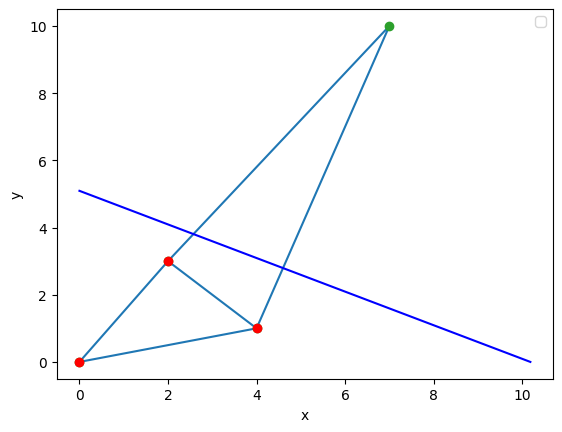

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8.504663517808309 2.6355528175150487


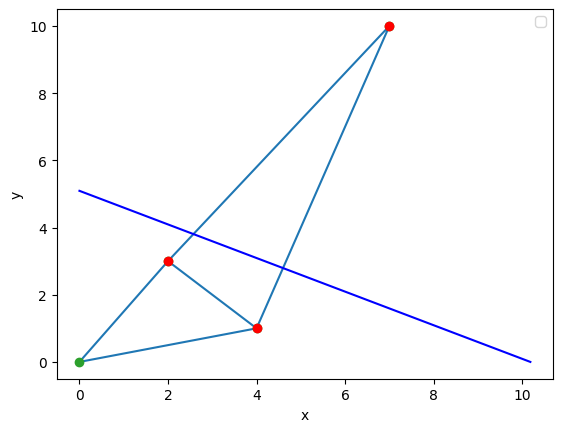

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The loss is:  2.1748398348415003e-05
The enclosing area is:  8.504663517808309
一半面积：  8.5
dL/dC is:  0.02458189499844068


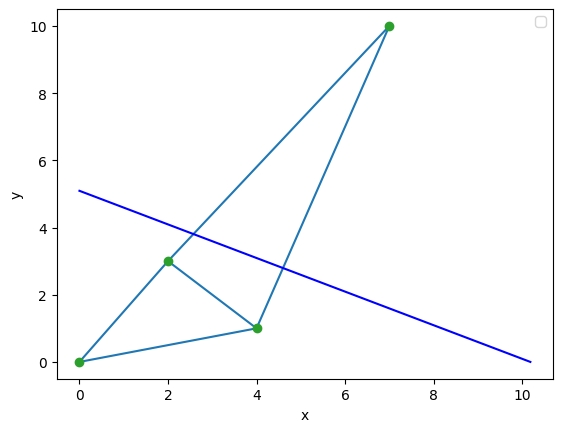

In [280]:
test.train_one_round()

In [168]:
class problem_mesh_2D:
    def __init__(self, points, faces, slope=[1,2], ratio=0.5, learning_rate=0.05, num_iteration=1000):
        if len(points) < 3:
            A = np.array([6,9])
            B = np.array([10,14])
            C = np.array([8,28])
            self.vertices = np.array([A, B, C])
        else:
            self.vertices = points
        self.faces = faces
        
        # Initialize variable "C"
        c = -5
    
        # Decision boundary
        self.line = util.line_2D([0,0], [0,0], slope + [c])
        
        # Area realted
        self.ratio = ratio
        self.compute_mesh_area()
        
        # Learning realted
        self.lr = learning_rate
        self.num_iteration = num_iteration
        
    def compute_mesh_area(self):
        self.area = 0
        for face in self.faces:
            index_A, index_B, index_C = face
            A = points[index_A]
            B = points[index_B]
            C = points[index_C]
            self.area += util.triangle_area(A, B, C)
        return self.area
    
    def forward_propagate(self):
        A, B, C = self.line.coef
        self.S = 0
        self.dS_C = 0
        
        size = len(self.faces)
        self.P = np.empty((size, 2))
        self.Q = np.empty((size, 2))
        self.R = np.empty((size, 2))
        self.dP_C = np.empty((size, 2, 2))
        self.dQ_C = np.empty((size, 2, 2))
        self.dR_C = np.empty((size, 2, 2))
        
        for idx, face in enumerate(self.faces):
            index_A, index_B, index_C = face
            A = points[index_A]
            B = points[index_B]
            C = points[index_C]
            
            # Edges
            line_AB = util.line_2D(A, B)
            line_BC = util.line_2D(B, C)
            line_CA = util.line_2D(C, A)
        
            # Compute point P, Q and R for each triangle
            A, B, C = self.line.coef
            if not(line_AB.is_parallel(self.line.coef)):
                A_, B_, C_ = line_AB.coef
                M = np.array([[A, B],[A_, B_]])
                self.dP_C[idx] = np.linalg.inv(M) @ np.array([[-1, 0], [0, -C_]])
                self.P[idx] = self.dP_C[idx] @ np.array([C, 1])

            if not(line_BC.is_parallel(self.line.coef)):
                A_, B_, C_ = line_BC.coef
                M = np.array([[A, B],[A_, B_]])
                self.dQ_C[idx] = np.linalg.inv(M) @ np.array([[-1, 0], [0, -C_]])
                self.Q[idx] = self.dQ_C[idx] @ np.array([C, 1])

            if not(line_CA.is_parallel(self.line.coef)):
                A_, B_, C_ = line_CA.coef
                M = np.array([[A, B],[A_, B_]])
                self.dR_C[idx] = np.linalg.inv(M) @ np.array([[-1, 0], [0, -C_]])
                self.R[idx] = self.dR_C[idx] @ np.array([C, 1])
                
            A = points[index_A]
            B = points[index_B]
            C = points[index_C]
            
            S_single, dS_C_single = self.compute_area_and_gradient_single(idx, np.array([A, B, C]))
            self.S += S_single
            self.dS_C += dS_C_single
            
            print (self.S, self.dS_C)
#             self.visualize_temp(np.array([A, B, C]))
        
            
#     Use variable "C" to compute the area of enclosing part and the gradient dS/dC, denoted by dS_C
    def compute_area_and_gradient_single(self, idx, vertices):
        A, B, C = vertices
        S = 0
        dS_C = 0
        if(self.line.interpolate(A) > 0):
            AR = self.R[idx] - A
            AP = self.P[idx] - A
            dAR_C = self.dR_C[idx].copy()
            dAR_C[:,1] -= A
            dAP_C = self.dP_C[idx].copy()
            dAP_C[:,1] -= A
            S += np.cross(AR, AP) / 2
            dS_C += self.cross_product_gradients(dAR_C, dAP_C) / 2
            
        if(self.line.interpolate(B) > 0):
            BP = self.P[idx] - B
            BQ = self.Q[idx] - B
            dBP_C = self.dP_C[idx].copy()
            dBP_C[:,1] -= B
            dBQ_C = self.dQ_C[idx].copy()
            dBQ_C[:,1] -= B
            S += np.cross(BP, BQ) / 2
            dS_C += self.cross_product_gradients(dBP_C, dBQ_C) / 2
            
        if(self.line.interpolate(C) > 0):   
            CQ = self.Q[idx] - C
            CR = self.R[idx] - C         
            dCQ_C = self.dQ_C[idx].copy()
            dCQ_C[:,1] -= C
            dCR_C = self.dR_C[idx].copy()
            dCR_C[:,1] -= C
            S += np.cross(CQ, CR) / 2
            dS_C += self.cross_product_gradients(dCQ_C, dCR_C) / 2
            
        return S, dS_C
    
    def loss_MSE(self):
        return np.power(self.S-self.ratio*self.area, 2)
    
#     def forward_propagation(self):
        
    def backward_propagation(self):
#         dL/dS
        dL_S = 2*self.S-2*self.ratio*self.area
#         dL/dC
        self.dL_C=dL_S*self.dS_C
        
    def update_parameters(self):
        A, B, C = self.line.coef
        C -= self.lr * self.dL_C
        self.line = util.line_2D([0,0], [0,0], np.array([A, B, C]))

    def cross_product_gradients(self, M1, M2):
        A, B, C = self.line.coef
        dS_C = problem_mesh_2D.cross_product_helper(M1[0], M2[1]) - problem_mesh_2D.cross_product_helper(M1[1], M2[0])
        return 2*dS_C[0]*C + 2*dS_C[1]
        
    @staticmethod
    def cross_product_helper(v1, v2):
        a, b = v1
        c, d = v2
        return np.array([a*c, a*d + b*c, b*d])
    
    def visualize(self):
        p1, p2 = self.line.get_two_points()
        util.v_line_2D(p1, p2)
        plt.triplot(points[:,0], points[:,1], self.faces)
        plt.plot(points[:,0], points[:,1], 'o')
        plt.legend()
        plt.show()
        
#     def visualize_temp(self, vertices):
#         p1, p2 = self.line.get_two_points()
#         util.v_line_2D(p1, p2)
        
#         plt.triplot(points[:,0], points[:,1], self.faces)
#         plt.plot(points[:,0], points[:,1], 'o')
#         plt.plot(vertices[:, 0], vertices[:, 1], 'o', color='r')
#         plt.legend()
#         plt.show()
    
    def train_one_round(self):
        self.forward_propagate()
        print("The loss is: ", self.loss_MSE())
        self.backward_propagation()
        self.update_parameters()
        
        print("The enclosing area is: ", self.S)
        print("一半面积： ", self.ratio*self.area)
        print("dL/dC is: ", self.dL_C)
        self.visualize()
        
    def train(self):
        for i in range(self.num_iteration):
            self.compute_PQR()
            self.S, self.dS_C = self.compute_area_and_gradient()
            self.backward_propagation()
            self.update_parameters()
        
        print("The loss is: ", self.loss_MSE())
        print("The enclosing area is: ", self.S)
        self.visualize()